In [9]:
import numpy as np
import pandas as pd
from pandas import read_csv, Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# see plt.style.available
%pylab inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

Populating the interactive namespace from numpy and matplotlib


/home/dk/anaconda2/envs/env_demand_prediction_v2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:
# -------------------------------------------------------------
# Note:
# For the following functions to run, 
# the data MUST be a Pandas Series with a valid datetime index
# -------------------------------------------------------------

def ts_decompose(ts):
    """
    Produce plots of a ts decomposed into components
    """
    decomposed_ts = seasonal_decompose(ts)  
    decomposed_df = pd.DataFrame({'observed': decomposed_ts.observed,
                                  'trend':  decomposed_ts.trend,
                                  'seasonal': decomposed_ts.seasonal, 
                                  'residual': decomposed_ts.resid})
    return decomposed_df[['observed', 'trend', 'seasonal', 'residual']]

def stationarity(ts):
    """
    Produce plot of rolling mean, stddev
    Results of the Dickey-Fuller Test
    """

    pd.DataFrame({'Actual': ts,
                  'Means': ts.rolling(window=12).mean(),
                  'Stddevs': ts.rolling(window=12).std()
                 }, index=ts.index).plot(figsize=(16, 8));

    test_df = adfuller(ts, autolag='AIC')

    result = pd.concat([pd.Series(test_df[:4], 
                                  index=['stat', 'pval', 'lags', 'numobs']),
                        pd.Series(test_df[4])])
    return result

## Data

In [11]:
# get the data from this url
# http://data.is/1Av1MJT
df = pd.read_csv('../data/external/portland-oregon-average-monthly-.csv')
df.columns = ['ts', 'y']
df.drop(114, inplace=True)
df.loc[:, 'y'] = df.y.astype(int)
df.loc[:, 'ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)

In [12]:
y = df['y']

In [13]:
y.head()

ts
1960-01-01    648
1960-02-01    646
1960-03-01    639
1960-04-01    654
1960-05-01    630
Name: y, dtype: int64

## 1. Visualize

---

- See if you can spot an overall/seasonal trend
- If there's no seasonal trend, use regular ARIMA
- If your data is very granular and there's a lot of variation, try resampling (reduce granularity to the day, week or month level) or look at rolling means

### Plot the time-series

The chart below has both - overall upward trend + seasonality

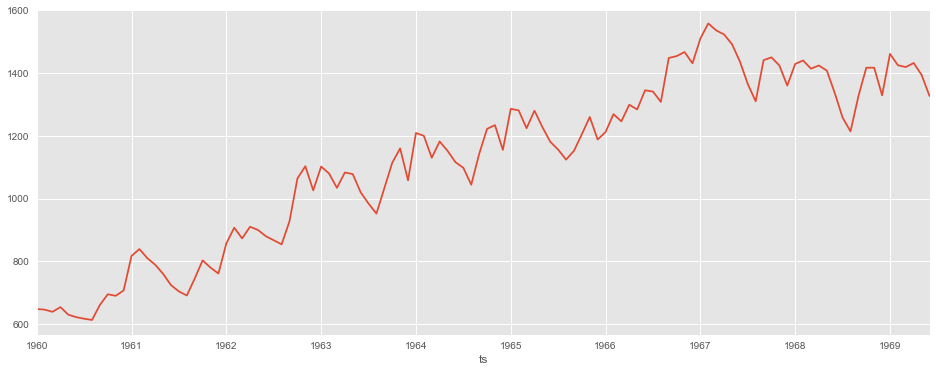

In [14]:
y.plot(figsize=(16, 6));

### Plot the decomposed time-series

- use the `seasonal_decompose` function in `statsmodels`
- The **residuals** essentially take the trend and seasonality out of the data, making the values independent of time. 
    - You could try to model the residuals using exogenous variables

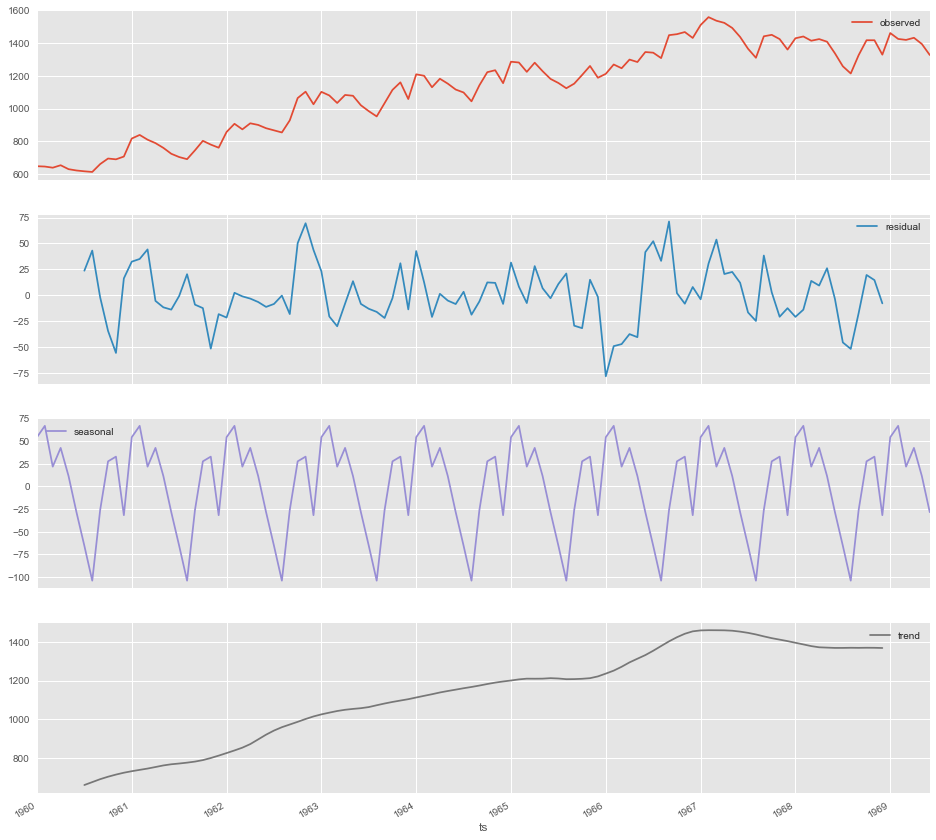

In [15]:
df_decomposed = ts_decompose(y, 12)
df_decomposed.plot(subplots=True, figsize=(16, 16));

#### On the same plot

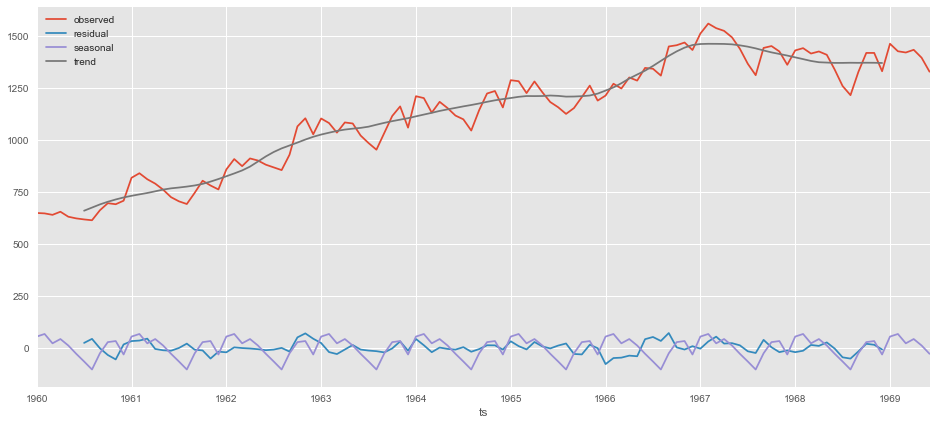

In [16]:
df_decomposed.plot(figsize=(16, 7));

## 2. Stationarize the data

---

### Why?

In Regression analysis, we assume that the data are $iid$. In time-series analyses however, we _know_ that the observations are time dependent. By making the data stationary, we can apply regression techniques to a time-dependent variable.

For stationarity, the data must obey the following assumptions

- $\mu \neq f(t)$, the mean shouldn't change over time
- $\sigma \neq f(t)$, the variance shouldn't change over time
- $cov(i, i+m) \neq f(t)$, the covariance should be constant over time

### Detect

Before we test a series for stationary, we need to remove the effect of unequal variances (ex. by taking the logarithm) and the trend component (ex. by taking difference of the series.) The number of differences needed to make the series stationary is the value of $d$ for ARIMA.

Non-stationarity can be detected by (a) visual inspection, (b) Dickey-Fuller Test (if stat > critical-value, data $\neq$ stationary)

### Treat

Transforming the data using log/lag/adjustments can make it stationary.

### Note

If, for example, the first lag appears to be stationary

- build an ARMA model on the first lag
- build an ARIMA model with I (order of integration) = 1

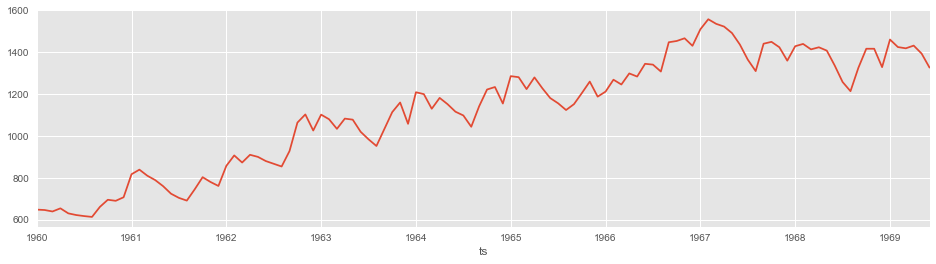

In [17]:
y.plot(figsize=(16, 4));

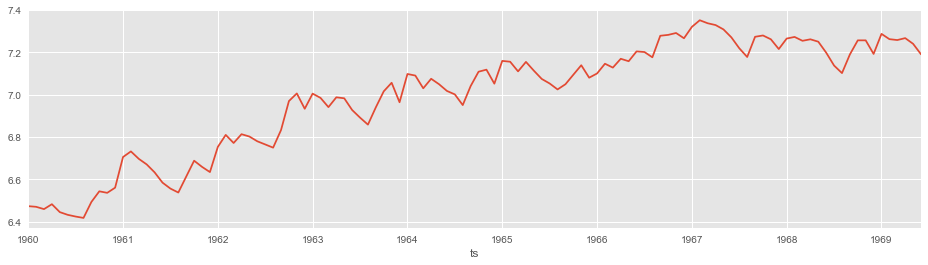

In [18]:
np.log(df['y']).plot(figsize=(16, 4));

> **Taking the log doesn't help much.**

stat       -1.536597
pval        0.515336
lags       12.000000
numobs    101.000000
1%         -3.496818
10%        -2.582277
5%         -2.890611
dtype: float64

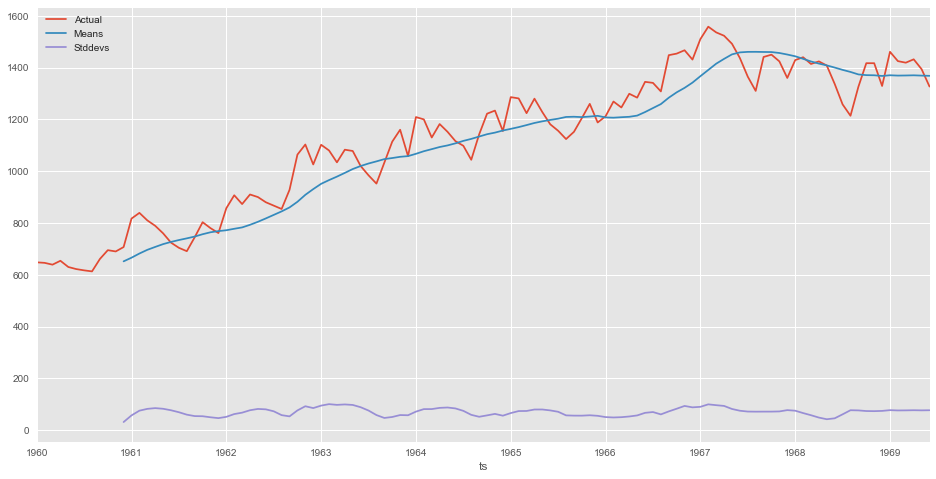

In [20]:
stationarity(y)

> **Here, `stat > crit` so we need to Transform the data**

### Detrending by removing the rolling means

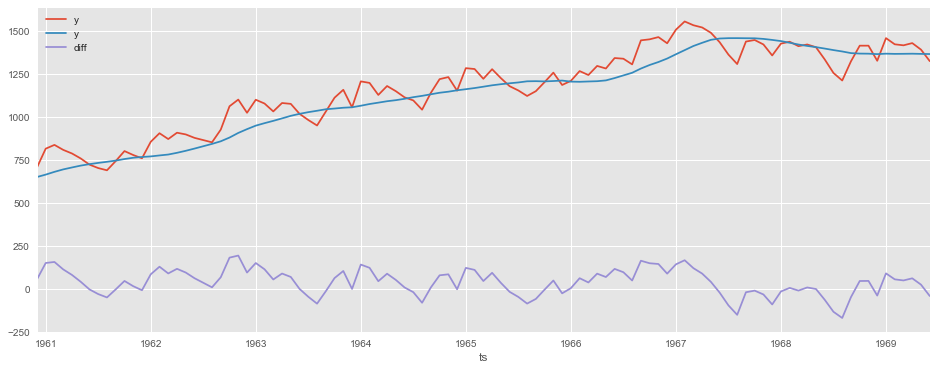

In [21]:
(pd.concat([y, y.rolling(window=12).mean()], axis=1)
 .dropna()
 .assign(diff = lambda x: x.iloc[:, 0] - x.iloc[:, 1])
).plot(figsize=(16, 6));

stat      -3.161179
pval       0.022345
lags      12.000000
numobs    90.000000
1%        -3.505190
10%       -2.584210
5%        -2.894232
dtype: float64

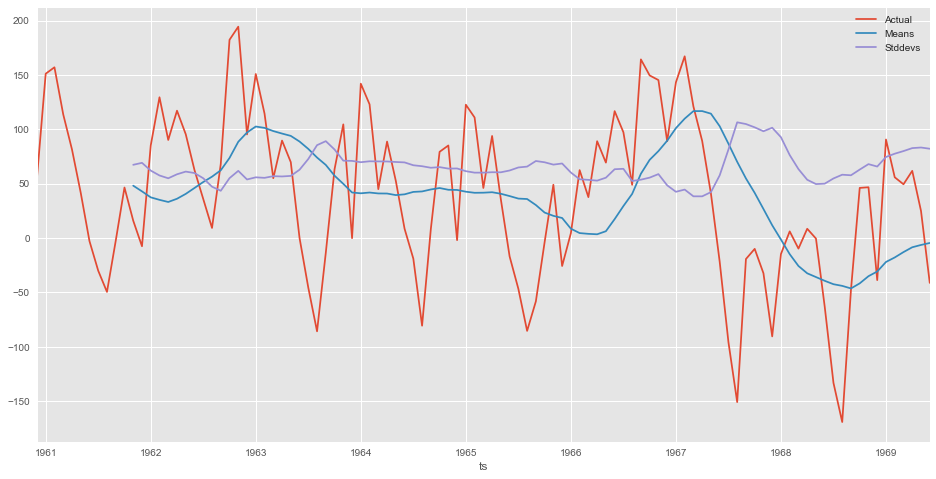

In [24]:
stationarity((y - y.rolling(window=12).mean()).dropna())

> **The p-value is less than 0.05!**

### Detrending using Lags

In [25]:
lag_01 = (y - y.shift(1)).dropna()

stat       -1.938696
pval        0.314082
lags       11.000000
numobs    101.000000
1%         -3.496818
10%        -2.582277
5%         -2.890611
dtype: float64

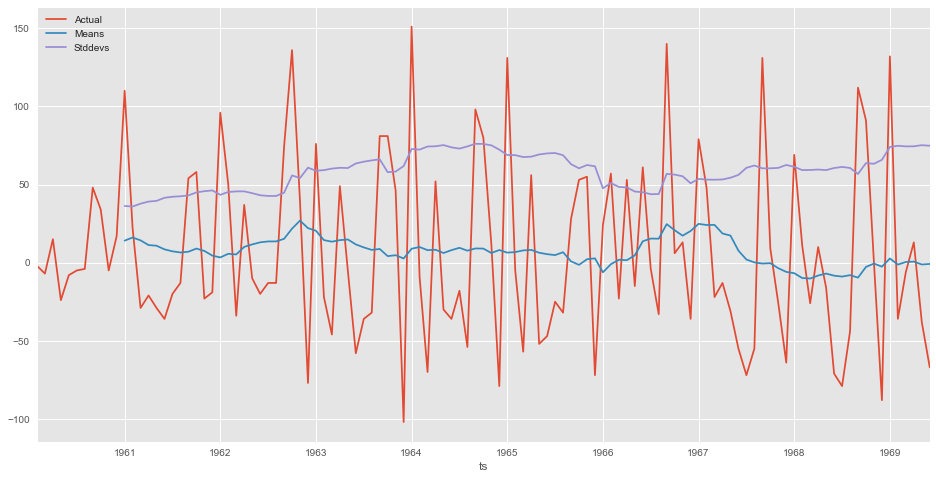

In [26]:
stationarity(lag_01)

> **Stationarity improved! Let's see if we can do better.**

### Seasonal Difference

In [27]:
seasonal_01 = (y - y.shift(12)).dropna() 

stat      -2.469741
pval       0.123011
lags       3.000000
numobs    98.000000
1%        -3.498910
10%       -2.582760
5%        -2.891516
dtype: float64

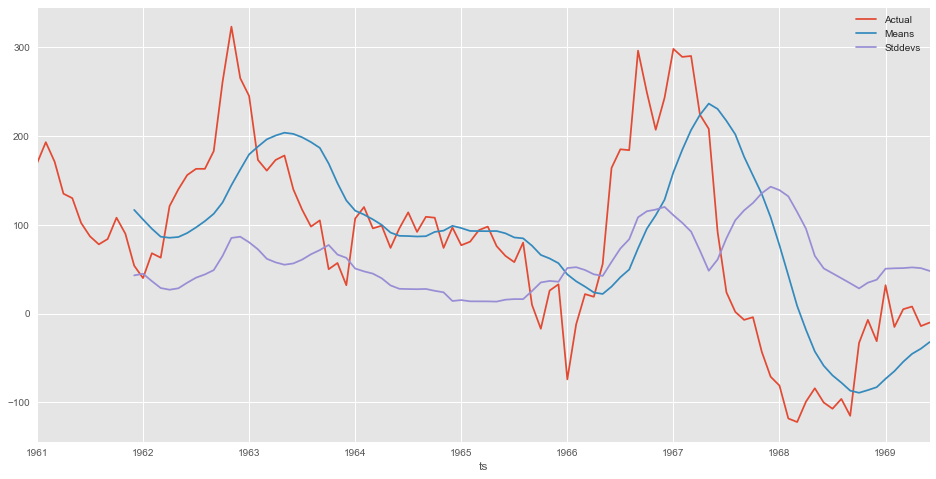

In [28]:
stationarity(seasonal_01)

> **pval still not significant.**

### First lag of the seasonal difference

stat     -9.258520e+00
pval      1.427874e-15
lags      0.000000e+00
numobs    1.000000e+02
1%       -3.497501e+00
10%      -2.582435e+00
5%       -2.890906e+00
dtype: float64

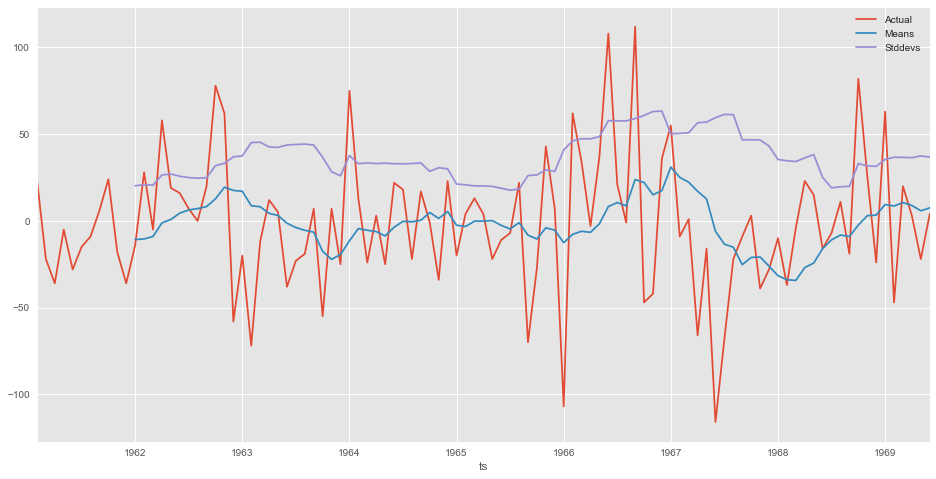

In [29]:
stationarity((lag_01 - lag_01.shift(12)).dropna())

> ** As you can see by the p-value, taking the seasonal first difference has now made our data stationary.**

## Plot ACF, PACF for different lags

The next step is **to determine the tuning parameters** (the appropriate AR, MA, SAR, and MAR terms) of the model by looking at the **autocorrelation and partial autocorrelation graphs.** 

> _Remember that a poor choice of the parameter set may lead to **over-fitting.**_

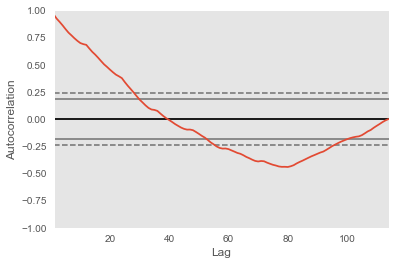

In [30]:
autocorrelation_plot(df['y'].dropna());

> **we can see that there is a positive correlation with the first 5-to-10 lags that is perhaps significant for the first 5 lags. A good starting point for the AR parameter of the model may be 5.**

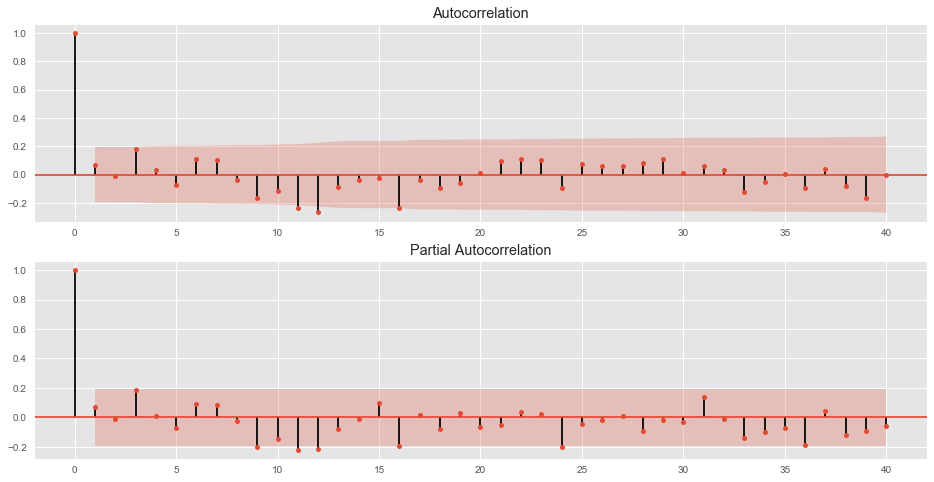

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
plot_acf((lag_01 - lag_01.shift(12)).dropna(), lags=40, ax=ax[0])
plot_pacf((lag_01 - lag_01.shift(12)).dropna(), lags=40, ax=ax[1]);

> Because the autocorrelation of the differenced series is negative at lag 12 (one year later), you should an SMA term to the model. Try out different terms. If you find that adding a SAR term improves the accuracy of the prediction for 1982, do it, but remember that by including this term, you could be overfitting the model. 

---

### Grid Search for time-series

Create a function that 

- fits models using all possible combinations of the parameters, 
- use these models to predict the outcome for multiple time periods, and - select the model with the smallest sum of squared errors.

# ARIMA

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
TS = df['y'].astype(float)

In [ ]:
TS.head()

In [ ]:
arima_model = ARIMA(TS, order=(2, 1, 0)).fit()
print arima_model.summary()

In [ ]:
arima_model.

### Study the Residuals

In [ ]:
# The appear random
arima_model.resid.plot(figsize=(16, 4));

In [ ]:
# appear Gaussian
arima_model.resid.plot.kde(figsize=(5, 4));

In [ ]:
# The mean is close to zero
arima_model.resid.mean()

### Predict with Rolling Forecasts

We can use the `forecast()` method of the model object to make predictions.

> For every next forecast, we take all available history up to that point. If there are exogenous variables, we must have their values in the future as well!

**Returns**

- `forecast` : Array of out of sample forecasts
- `stderr` : Array of the standard error of the forecasts.
- `conf_int` : 2d array of the confidence interval for the forecast

In [ ]:
ARIMA?

In [ ]:
TS.plot();

In [ ]:
TS2 = TS.copy()

# split the data
tr, te = list(TS2.values[:100]), list(TS2.values[100:])
FORECASTS = [] 

# we'll train a model for each value to be forecasted
for i,actual in enumerate(te):
    model = ARIMA(tr, order=(5, 1, 0)).fit(disp=0)
    fcast = model.forecast()
    FORECASTS.append(fcast)
    tr.append(actual)
    print actual, round(fcast[0], 2)

In [ ]:
df2 = pd.DataFrame({'y': TS[-len(te):].values,
                    'yhat': map(lambda x: x[0][0], FORECASTS),
                    'lower_bound': map(lambda x: x[2][:, 0][0], FORECASTS),
                    'upper_bound': map(lambda x: x[2][:, 1][0], FORECASTS)})

print "MSE={}".format(mean_squared_error(df2['y'], df2['yhat']))
df2[['y', 'yhat']].plot(figsize=(10, 3), style='-.', alpha=0.5);

## Box-Jenkins Methodology for finding appropriate $p,d,q$

---

- **Model Identification** Use plots and summary statistics to **identify trends, seasonality, and autoregression elements** to get an idea of the amount of differencing and the size of the lag that will be required.
- **Parameter Estimation** Use a fitting procedure to find the coefficients of the regression model.
- **Model Checking** Use plots and statistical tests of the residual errors to determine the amount and type of temporal structure not captured by the model.

In summary, Grid Search

1. Guess a combination of (p,d,q)
2. Modeling and Performance Evaluation
3. Repeat until either a desirable level of fit is achieved on out-of-sample observations

# SARIMAX

```python
mod = sm.tsa.statespace.SARIMAX(ts, order=ORDER)
```
where, `ORDER` is a tuple of the form (**AR** specification, **I**ntegration order, **MA** specification)


In [ ]:
SARIMAX?

In [ ]:
mod = sarimax.SARIMAX(df['y'],
                      trend='n', 
                      order=(0,1,0), 
                      seasonal_order=(1,1,1,12))
srmx = mod.fit()
print srmx.summary()

### Prediction on Train Data

In [ ]:
df['yhat'] = srmx.predict(start=100, dynamic=True)  
df[['y', 'yhat']].plot(figsize=(12, 8))

### Prediction on Test Data

In [ ]:
test = pd.DataFrame(index=pd.date_range(df.index.max(), periods=24, freq='MS'),
                    columns=df.columns)
test.head()

In [ ]:
df = pd.concat([df, test])
df['yhat'] = np.nan

In [ ]:
df.loc[:, 'yhat'].iloc[114:138, :] = srmx.predict(start=114, end=138)

In [ ]:
df.plot(figsize=(16, 6))